#**Tutorial for the Columbia HAZard (CHAZ) model** - Downscaling

---
The beta version of CHAZ can be downloaded from GitHub https://github.com/cl3225/CHAZ. This tutorial converts the scripts into JupyterNB for better understanding of each of the components.

n.b. 
- Minimally edited version of original code. Adjustments have double octothorpes (##) to indicate changes 
- all `np.float64` replaced with `np.float64`
- all `np.NaN` replaced with `np.nan`

- replaced/froze rng  in intensity calculation to try to compare with vectorize

In [1]:
#!pip install netCDF4
#!pip install cartopy

In [2]:
# Import necessary libraries
import numpy as np
from numpy import nanmean

import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
import random
from scipy.io import netcdf_file
from scipy.io import loadmat
from scipy import stats

import calendar
from datetime import datetime,timedelta
import time
import sys
import dask.array as da
import numpy.ma as ma
import gc
from netCDF4 import Dataset,date2num,num2date
import netCDF4 as nc
from dask.diagnostics import ProgressBar

import subprocess
import pickle
import copy
#import random

import pooch

## profiling code to look for efficiency gains
import cProfile 


Create a random number generator from a set seed, for code testing and reproducibility. 

In [3]:
## adding random number generator with set seed to allow comparisons and reproducibility
## set seed = None to use computer chaos
seed = 42
rng = np.random.default_rng(seed=seed)

In [4]:
def get_landmask():
    """
    read 0.25degree landmask.nc
    output:
    lon: 1D
    lat: 1D
    landmask:2D

    """
    fopen = pooch.retrieve(url=f"{path_data}/landmask.nc",  known_hash=None)
    f = netcdf_file(fopen)
    lon = f.variables['lon'][:]
    lat = f.variables['lat'][:]
    landmask = f.variables['landmask'][:,:]
    f.close()

    return lon, lat, landmask

## Step 0: Model basic settings

In [5]:
path_data = 'doi:10.5281/zenodo.11631930' # public data available at https://zenodo.org/records/11628647
yearTC = 2017

# Use class to define the global variables:
class gv():
    ### Experiment settings
    Model = 'ERA5'
    ENS = 'r1i1p1f1'
    TCGIinput = 'TCGI_CRH_PI' # or "TCGI_SD_RI"
    CHAZ_ENS = 1 # Number of track realiazations
    CHAZ_Int_ENS = 40 # Number of intensity realiazations

    ### CHAZ parameters & other inputs path
    uBeta = -1.5
    vBeta = 2.0
    survivalrate = 0.78
    seedN = 1000 #annual seeding rate for random seeding
    obpath = 'bt_global_predictors.nc'

    llon, llat,lldmask = get_landmask()
    ldmask = lldmask[-12::-24,::24]
    lldmask = lldmask[::-1,:]

/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_14851/1271100312.py:15: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  f.close()


## Step 1: Tropical Cyclogenesis

This part seed TC disturbnaces based on the TCGI fields from pre-process code

In [6]:
def TCgiSeeding (gxlon, gxlat, gi, climInitLon, climInitLat, climInitDate, ratio, iy):
    '''
    This is a subroutine for calculating genesis location based on gi.

    gi (Month X nlat X nlon):
        gi is tropical cyclone genesis index. We use nansum(gi) to for
        totoal number of seeds, and then randomly select location using gi
        as genesis probability.
    gxlon (nlat X nlon): mesh-grid longitude
    gxlat (nlat X nlon): mesh-grid latitude
    climInitLon,climInitLat,climInitDate: list contains previous seeds information
    ratio: how much more seeds we should gives, based on the survival rate
    '''
    for im in range(12):
        xk, pk = np.arange(gi[im,:,:].size), gi[im,:,:].ravel()
        dummy = xk*pk
        xk, pk = xk[dummy==dummy], pk[dummy==dummy]
        ## updated seed to use set rng
        custm = stats.rv_discrete(name='custm', values=(xk, pk/pk.sum()), seed = rng)
        r = custm.rvs(size=np.int_(np.rint(pk.sum()*ratio)))
        iix = gxlon.ravel()[r.ravel()]
        iiy = gxlat.ravel()[r.ravel()]
        
        ## update to use set rng
        ##iday = np.random.choice(np.arange(calendar.monthrange(iy,im+1)[1]), size=np.int_(np.rint(pk.sum()*ratio)), replace=True)
        iday = rng.choice(np.arange(calendar.monthrange(iy,im+1)[1]), size=np.int_(np.rint(pk.sum()*ratio)), replace=True)

        if iday.size>0:
            for id in range(iday.size):
                x1 = np.arange(iix[id]-1,iix[id]+1.01, 0.01)
                y1 = np.arange(iiy[id]-1,iiy[id]+1.01, 0.01)
                ## update to use set rng
                ##xx = np.random.choice(x1,1)
                ##yy = np.random.choice(y1,1)
                xx = rng.choice(x1,1)
                yy = rng.choice(y1,1)
                climInitDate.append(datetime(iy,im+1,iday[id]+1,0,0))
                climInitLon.append(xx)
                climInitLat.append(yy)

    return climInitLon, climInitLat, climInitDate

def getSeeding(iy, ratio):
    climInitLon = []
    climInitLat = []
    climInitDate = []

    # Load the tropical cyclone genesis index (TCGI)
    tcgiFile = pooch.retrieve(url=f"{path_data}/{gv.TCGIinput}_{iy:04d}.nc",  known_hash=None)
    ds = xr.open_dataset(tcgiFile)
    gi = ds.TCGI.values

    # Load longitude and latitude data
    xlon = ds['lon']
    xlat = ds['lat']

    # Create a meshgrid of longitude and latitude
    gxlon,gxlat = np.meshgrid(xlon,xlat)

    # Generate seeds based on the genesis index
    climInitLon,climInitLat,climInitDate = \
        TCgiSeeding (gxlon,gxlat,gi,climInitLon,climInitLat,climInitDate,ratio,iy)

    # Convert lists to numpy arrays and flatten them
    climInitDate = np.array(climInitDate).ravel()
    climInitLon = np.array(climInitLon).ravel()
    climInitLat = np.array(climInitLat).ravel()

    return climInitDate,climInitLon, climInitLat

In [7]:
ratio = 1 # ratio is a form of corretion in case the global TCGI number is too low
climInitDate, climInitLon, climInitLat = getSeeding(yearTC, ratio)

In [8]:
climInitDate[0:3]

array([datetime.datetime(2017, 1, 6, 0, 0),
       datetime.datetime(2017, 1, 29, 0, 0),
       datetime.datetime(2017, 1, 25, 0, 0)], dtype=object)

/Users/miriam/miniforge3/envs/chaz_env/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:1677: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


(-40.0, 40.0)

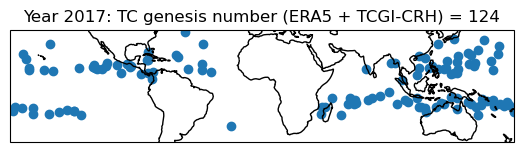

In [9]:
# Plot to see TC gensis locations:
import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature

MyFigsize,MyFontsize = (6.5,4),8
londis, latdis = 30, 15
lon1, lon2 = 10,350
lat1, lat2 = -60, 60
my_proj = ccrs.PlateCarree(central_longitude=180)
data_ccrs = ccrs.PlateCarree()

fig = plt.figure(figsize=MyFigsize)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(zorder=100)
ima = plt.scatter(climInitLon, climInitLat,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r,zorder=0)
#ax.set_extent([lon1,lon2,lat1,lat2])
plt.title(f'Year {yearTC}: TC genesis number (ERA5 + TCGI-CRH) = {len(climInitLon)}')
plt.ylim(-40, 40)

Plot genesis days

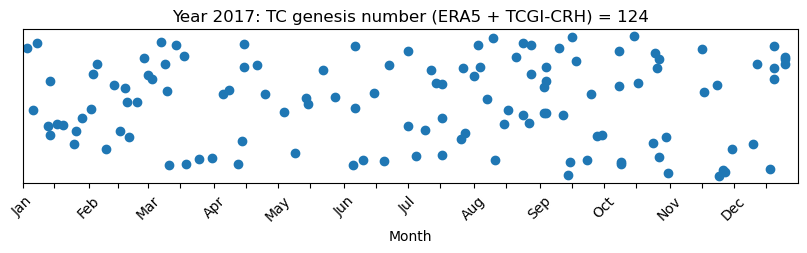

In [10]:
dates = pd.to_datetime(climInitDate)

# Extract day-of-year (1-365) for x-axis
days = dates.dayofyear

# Add a small random vertical offset so overlapping dots are visible
#y = np.random.rand(len(days)) * 0.1 + 0.5  # all dots roughly in the middle
y = rng.random(len(days)) * 0.1 + 0.5


# Plot
plt.figure(figsize=(10, 2))
plt.scatter(days, y, marker='o')
plt.yticks([])  # hide y-axis

# Create x-axis ticks: start and middle of each month
tick_positions = []
tick_labels = []

for month in range(1, 13):
    start_day = datetime(2017, month, 1).timetuple().tm_yday
    mid_day = start_day + calendar.monthrange(2017, month)[1] // 2
    tick_positions.extend([start_day, mid_day])
    tick_labels.extend([calendar.month_abbr[month], ''])

plt.xticks(tick_positions, tick_labels, rotation=45)
plt.xlabel('Month')
#plt.title('TC Seed Dates in 2017')
plt.title(f'Year {yearTC}: TC genesis number (ERA5 + TCGI-CRH) = {len(climInitDate)}')

plt.xlim(1, 365)
plt.show()


## Step 2: Tracks
This part moves the initial seeds forward using a beta-advection model. It takes time.




In [11]:
def func_first(x):
    if x.first_valid_index() is None:
        return None
    else:
        return x.first_valid_index()

def func_last(x):
    if x.last_valid_index() is None:
        return None
    else:
        return x.last_valid_index()

def removeland(iS):
    #print iS
    b = np.int_(iS.mean(keepdims=True))
    iT3 = -1
    if b<fstldmask.shape[1]:
        a = np.argwhere(fstldmask[:,b]==3).ravel()
        if a.size:
            if a.size>3:
                iT3 = a[0]+2
                fstlon[iT3:,b]=np.nan
                fstlat[iT3:,b]=np.nan
    return iT3

def calF(nday):
    #### furior function
    dt = 1.0*60*60 #1 hr  # Time step in seconds (1 hour)
    #T = np.float64(nday)
    T = np.float64(15) #15-day period of the fourier series
    N = 15 #Number of sine waves
    nt = np.arange(0,nday*60*60*24, dt)
    F = np.zeros([nt.shape[0], 4])
    F1 = np.zeros([nt.shape[0], 4])
    #F = np.zeros([24,4])
    #F1 = np.zeros([24,4])
    for iff in range(0, 4, 1):
        X = np.zeros([15])
        ## update to use set rng
        ##X = [random.uniform(0,1) for iN in range(N)]
        X = [rng.uniform(0, 1) for iN in range(N)]
        for itt in range(nt.shape[0]):
            F[itt,iff] = (np.sqrt(2.0/np.sum([iN**(-3.0) for iN in range(1,N+1,1)]))*\
                np.sum([(iN**(-3.0/2.0))*np.sin(2.0*np.pi*(iN*itt/(24.*T)+X[iN-1]))
                   for iN in range(1,N+1,1)]))
    return F


def fillinNaN(var, neighbors):
    """
    Replace masked areas using interpolation.
    """
    for ii in range(var.shape[0]):
        a = var[ii, :, :]
        while np.any(a.mask):
            a_copy = a.copy()
            for hor_shift, vert_shift in neighbors:
                if not np.any(a.mask):
                    break
                a_shifted = np.roll(np.roll(a_copy, shift=hor_shift, axis=1), shift=vert_shift, axis=0)
                idx = a.mask & ~a_shifted.mask
                a[idx] = a_shifted[idx]
        var[ii, :, :] = a
    return var

def date_interpolation(dateInput,fileInput):
        """
        fileInput is a 3-d gloabl fields  with time-axis on the first column, eg. fileInput[it,ix,iy]
        the function return fields interpolated linearly to date on dateInput.
        if dateInput.month is December, then it returns Dec. field
        """
        if dateInput.day >= 15:
                if dateInput.month < 12:
                        date0 = datetime(dateInput.year,dateInput.month,15,0,0)
                        date1 = datetime(dateInput.year,dateInput.month+1,15,0,0)
                        dfdays = (dateInput-date0).days
                        xp = [0, (date1-date0).days]
                        ratio = np.interp(dfdays,xp,[0,1])
                        fileOutput = fileInput[dateInput.month-1,:,:]*(1-ratio)+fileInput[dateInput.month,:,:]*(ratio)
                else:
                        fileOutput= fileInput[dateInput.month-1,:,:]
        else:
                if dateInput.month == 1:
                        fileOutput= fileInput[dateInput.month-1,:,:]
                else:
                        date0 = datetime(dateInput.year,dateInput.month-1,15,0,0)
                        date1 = datetime(dateInput.year,dateInput.month,15,0,0)
                        dfdays = (dateInput-date0).days
                        xp = [0, (date1-date0).days]
                        ratio = np.interp(dfdays,xp,[0,1])
                        fileOutput = fileInput[dateInput.month-2,:,:]*(1-ratio)+fileInput[dateInput.month-1,:,:]*ratio
        return fileOutput

def getTrackPrediction(u250,v250,u850,v850,dt,fstLon,fstLat,fstDate):
    #### modify Beta
    earth_rate = 7.2921150e-5 #mean earth rotation rate in radius per second
    r0 = 6371000 # mean earth radius in m
    lat0 = np.arange(-90,100,10)
    phi0 = lat0/180.*np.pi #original latitude in radian (ex. at 15 degree N)
    beta0 = 2.0*earth_rate*np.cos(phi0)/r0 # per second per m
    beta0 = beta0/beta0[10]
    ratio = np.interp(fstLat,np.arange(-90,100,10),beta0)
    uBeta = gv.uBeta*ratio
    vBeta = gv.vBeta*ratio
    ################

    alpha = 0.8
    uTrack = alpha*u850+(1.-alpha)*u250+uBeta
    vTrack = alpha*v850+(1.-alpha)*v250+vBeta*np.sign(np.sin(fstLat*np.pi/180.))
    dx = uTrack*dt
    dy = vTrack*dt
    lon2,lat2 = getLonLatfromDistance(fstLon,fstLat,dx,dy)
    fstLon,fstLat = lon2,lat2
    fstDate += timedelta(seconds=dt)
    #print uBeta, vBeta,fstLon,fstLat

    return fstLon,fstLat,fstDate

def getLonLatfromDistance(lonInit,latInit,dx,dy):
    er = 6371000 #km
    londis = 2*np.pi*er*np.cos(latInit/180*np.pi)/360.
    lon2 = lonInit+dx/londis
    latdis = 2*np.pi*er/360.
    lat2 = latInit+dy/latdis
    return lon2,lat2

def bam(iS,block_id=None):
    """
    Simulates the track of a tropical cyclone.

    Parameters:
    iS (array): Index of the initial condition for the simulation.
    block_id (optional): Dask block identifier.

    Returns:
    ##int: Index of the initial condition.
    """
    # [1] Generate F from Emanuel et. al. (2006). It is a Fourier series where the individual wave components have a random phase.
    neighbors=((0,1),(0,-1),(1,0),(-1,0),(1,1),(-1,1),(1,-1),(-1,-1),(0,2),(0,-2),(2,0),(-2,0)) ##
    missing_value =  1e+20

    dt = 1.0*60*60
    T = np.float64(15)
    F = calF(15)
    nt = np.arange(0,T*60*60*24,dt)
    b = np.int_(iS.mean(keepdims=True)[0])
    #b = iS
    fstDate = climInitDate[b]
    fstLon = climInitLon[b]
    fstLat = climInitLat[b]
    fstlon[0,b] = fstLon
    fstlat[0,b] = fstLat
    fstldmask[0,b] = 0
    endhours = fstlon.shape[0]-1
    endDate = climInitDate[b] + timedelta(hours = endhours)
    count,year0,month0,day0 = 1,0,0,0

    FileAName = pooch.retrieve(url=f"{path_data}/A_{fstDate.year:04d}{fstDate.month:02d}.nc",  known_hash=None)
    dsA = xr.open_dataset(FileAName)
    A_matrix = dsA.variables['A'].load()
    dsA.close()
    month0 = fstDate.month


    while fstDate < endDate and fstDate.year==yearTC:
        if (fstDate.year != year0):
            fileName = pooch.retrieve(url=f"{path_data}/I_MLR_{fstDate.year:04d}.nc",  known_hash=None)
            try:
                ds = xr.open_dataset(fileName)
                u250m = ds['u250'].values
                u850m = ds['u850'].values
                v250m = ds['v250'].values
                v850m = ds['v850'].values
                for data in [u250m, u850m, v250m, v850m]:
                    data[np.isnan(data)] = missing_value
                    data = np.ma.masked_values(data, missing_value)
                    data = fillinNaN(data, neighbors)

                xlong = ds['lon'][:]
                xlat = ds['lat'][:]
                xxlong,xxlat = np.meshgrid(xlong,xlat)
                ds.close()
                year0 = fstDate.year
            except:
                print('no'+fileName)
                break
        if fstDate.day != day0:
            #print fstDate.day,day0
            u250m2d = date_interpolation(fstDate,u250m)
            v250m2d = date_interpolation(fstDate,v250m)
            u850m2d = date_interpolation(fstDate,u850m)
            v850m2d = date_interpolation(fstDate,v850m)
            day0=fstDate.day

        #print(f'\n {fstDate}')
        #print(f"{path_data}/A_{fstDate.year:04d}{fstDate.month:02d}.nc")
        if (fstDate.month != month0):
            FileAName = pooch.retrieve(url=f"{path_data}/A_{fstDate.year:04d}{fstDate.month:02d}.nc",  known_hash=None)
            dsA = xr.open_dataset(FileAName)
            A_matrix = dsA.variables['A'].load()
            dsA.close()
            month0 = fstDate.month
        A = A_matrix[:,fstDate.day-1,:,:]
        day0 = fstDate.day

        distance = np.sqrt((fstLon-xxlong)**2+(fstLat-xxlat)**2)
        iy,ix = np.unravel_index(np.argmin(distance),distance.shape)
        iy1,ix1 = np.max([iy-2,0]),np.max([ix-2,0])
        iy2,ix2 = np.min([iy+2,distance.shape[0]]),np.min([ix+2,distance.shape[1]])

        iit = np.mod(count,nt.shape[0])
        u250 = u250m2d[iy1:iy2+1,ix1:ix2+1]+A[0,iy1:iy2+1,ix1:ix2+1]*F[iit,0]
        v250 = v250m2d[iy1:iy2+1,ix1:ix2+1]+A[1,iy1:iy2+1,ix1:ix2+1]*F[iit,0]+A[2,iy1:iy2+1,ix1:ix2+1]*F[iit,1]
        u850 = u850m2d[iy1:iy2+1,ix1:ix2+1]+A[3,iy1:iy2+1,ix1:ix2+1]*F[iit,0]+\
                         A[4,iy1:iy2+1,ix1:ix2+1]*F[iit,1]+A[5,iy1:iy2+1,ix1:ix2+1]*F[iit,2]
        v850 = v850m2d[iy1:iy2+1,ix1:ix2+1]+A[6,iy1:iy2+1,ix1:ix2+1]*F[iit,0]+\
                         A[7,iy1:iy2+1,ix1:ix2+1]*F[iit,1]+A[8,iy1:iy2+1,ix1:ix2+1]*F[iit,2]+\
                         A[9,iy1:iy2+1,ix1:ix2+1]*F[iit,3]


        u250 = np.nanmean(u250)
        u850 = np.nanmean(u850)
        v250 = np.nanmean(v250)
        v850 = np.nanmean(v850)

        fstLon, fstLat, fstDate = getTrackPrediction(u250,v250,u850,v850,dt,fstLon,fstLat,fstDate)
        #print fstDate,year0,day0
        if ((fstLon<0.0) or (fstLon>360) or (fstLat<-60) or (fstLat>60)):
            #print b, 'break for going to the space'
            break
        fstlon[count,b] = fstLon
        fstlat[count,b] = fstLat
        fstldmask[count,b] = np.rint(np.nanmean(gv.ldmask[iy1:iy2+1,ix1:ix2+1]))
        del u250,u850,v250,v850
        count += 1

    return b

def getBam(cDate,cLon,cLat,iy,ichaz):
    global climInitDate,climInitLon,climInitLat
    climInitDate,climInitLon,climInitLat = cDate,cLon,cLat
    nnt = np.int_(31) # longest track time
    nS = climInitLon.shape[0]
    global fstlon, fstlat, fstldmask
    fstlon = np.zeros([nnt*24+1,nS])*np.nan
    fstlat = np.zeros([nnt*24+1,nS])*np.nan
    fstldmask = np.zeros(fstlat.shape)
    diS = da.from_array(np.arange(0,nS,1).astype(dtype=np.int32),chunks=(1,))
    niS = np.arange(0,nS,1).astype(dtype=np.int32)
    new = da.map_blocks(bam, diS,chunks=(1,), dtype=diS.dtype)
    with ProgressBar():
        b = new.compute(scheduler='synchronous', num_workers=5)
    #for iS in niS:
    #    b = bam(np.array([iS,iS]))
    #print(fstlon[2,:])
    print('removeland')
    #sys.exit()
    fstlon = fstlon[::6,:]
    fstlat = fstlat[::6,:]
    fstldmask = fstldmask[::6,:]
    #for iS in niS:
    #    c = removeland(np.array([iS,iS]))
    new = da.map_blocks(removeland,diS,chunks=(1,), dtype=diS.dtype)
    with ProgressBar():
         c = new.compute(scheduler='synchronous',num_workers=5)
    print('give times')
    ### give times
    fsttime = np.empty(fstlon.shape,dtype=object)
    fsttime[0,:] = climInitDate
    dummy = pd.DataFrame(fstlon)
    #import pdb;pdb.set_trace()
    iT1 = np.int16(dummy.apply(func_first,axis=0))+1
    iT2 = np.int16(dummy.apply(func_last,axis=0))

    for iS in niS:
        fsttime[iT1[iS]:iT2[iS]+1,iS] = \
        [climInitDate[iS]+timedelta(hours=6*iit) for iit in range(iT1[iS],iT2[iS]+1,1)]
        fst = {'lon':fstlon,'lat':fstlat,'Time':fsttime,'ldmask':fstldmask}

    return fst

## Get predictors:
class fst2bt(object):
    """
      convert data format from fst to be format
    """
    def __init__(self,data):
        self.StormId = np.arange(0,data['lon'].shape[1],1)
        self.StormYear = []
        self.StormInitMonth = []
        for iS in self.StormId:
            if data['Time'][0,iS] is not None:
                self.StormYear.append(data['Time'][0,iS].year)
                self.StormInitMonth.append(data['Time'][0,iS].month)
            else:
                self.StormYear.append(1800)
                self.StormInitMonth.append(1)
        self.StormYear = np.array(self.StormYear)
        self.StormInitMonth = np.array(self.StormInitMonth)
        for iS in range(data['Time'].shape[1]):
            data['Time'][:,iS] = np.array([datetime(1800,1,1,0) if v is None else v for v in data['Time'][:,iS]])
        data['Time'][data['lon']!=data['lon']] = datetime(1800,1,1,0)
        data['lon'][data['Time']==datetime(1800,1,1,0)] = np.float64('Nan')
        self.StormLon = data['lon']
        self.StormLat = data['lat']
        self.Time = data['Time']
        self.PIwspd = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.PIslp = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.PIwspdMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.dPIwspd = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.PIslpMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.UShearMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.UShear = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.VShearMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.VShear = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.div200Mean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.div200 = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.T200Mean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.T200 = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.rh500_300Mean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.rh500_300 = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.rhMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.rh = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.T100Mean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.T100 = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.dThetaEMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.dThetaE = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.dThetaEs = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.dThetaEsMean = np.empty(data['lon'].shape,dtype=float)*np.float64('Nan')
        self.landmask = data['ldmask']
        self.landmaskMean = data['ldmask']
        self.trSpeed = np.zeros(data['lon'].shape)*np.float64('Nan')
        self.trDir = np.zeros(data['lon'].shape)*np.float64('Nan')
        self.dVdt = np.zeros(data['lon'].shape)

def getSpeedDir(iiS,block_id=None):
    iS = np.int_(iiS.mean(keepdims=True)[0])
    if (bt.StormLat[:,iS]==bt.StormLat[:,iS]).any():
        it1 = np.argwhere(bt.StormLat[:,iS]==bt.StormLat[:,iS])[0,0]
        it2 = np.argwhere(bt.StormLat[:,iS]==bt.StormLat[:,iS])[-1,0]
        if it2 - it1 >=2:
            bt.trDir[it1:it2,iS],bt.trSpeed[it1:it2,iS]=\
                getStormTranslation(bt.StormLon[it1:it2,iS],\
            bt.StormLat[it1:it2,iS],bt.Time[it1:it2,iS])
    return iS

def getStormTranslation(lon,lat,time):
    er = 6371.0 #km
    timeInt=[]
    lonInt=[]
    latInt=[]

    for iN in range(time.shape[0]-1):
        timeInt.append(time[iN])
        lonInt.append(lon[iN])
        latInt.append(lat[iN])
        #delt = (time[iN+1]-time[iN]).seconds/60/60
        #if delt ==0:
        #   print time
        delt = 6
        inv = 1./np.float64(delt)
        #if time[iN+1]-time[iN] == timedelta(hours=delt):
        for iM in range(1,delt,1):
            timeInt.append(time[iN]+timedelta(hours=iM))
            lonInt.append((1.-iM*inv)*lon[iN]+iM*inv*lon[iN+1])
            latInt.append((1.-iM*inv)*lat[iN]+iM*inv*lat[iN+1])

    speed = np.zeros(lon.shape[0],dtype=float)+float('nan')
    sdir = np.zeros(lon.shape[0],dtype=float)+float('nan')
    count = 0
    for it in time:
        nup = argminDatetime(it+timedelta(hours=3),timeInt)
        ndn = argminDatetime(it-timedelta(hours=3),timeInt)
        londis = 2*np.pi*er*np.cos(latInt[nup]/180*np.pi)/360
        dlon = lonInt[nup]-lonInt[ndn]
        dlat = latInt[nup]-latInt[ndn]
        dx = londis*(lonInt[nup]-lonInt[ndn])
        dy = 110*(latInt[nup]-latInt[ndn])
        distance = np.sqrt(dx*dx+dy*dy) #km
        sdir[count]=np.arctan2(dlat,dlon)
        speed[count]=distance*1000./(nup-ndn+1)/60/60 #m/s
        count+= 1

    return sdir,speed

def argminDatetime(time0,time):
        """
        Returns the index of datetime array time for which
        the datetime time0 is nearest.
        """
        time = np.array(time)
        n0 = 0
        delt = np.abs(time[-1]-time[0])
        for n in range(time.size):
                if np.abs(time0-time[n]) < delt:
                        delt = np.abs(time0-time[n])
                        n0 = n
        return n0

def get_predictors(iiS,block_id=None):
    iS = np.int_(iiS.mean(keepdims=True)[0])
    predictors=['StormMwspd','dVdt','trSpeed','dPIwspd','SHRD','rhMean','dPIwspd2','dPIwspd3','dVdt2','landmaskMean']
    if bt.StormYear[iS]==yearTC:
      fileName = pooch.retrieve(url=f"{path_data}/I_MLR_{bt.StormYear[iS]:04d}.nc",  known_hash=None)
      ds = xr.open_dataset(fileName)
      xlong = ds['lon'].values
      xlat = ds['lat'].values
      PIVmax = ds['PI'].values * 1.94384449 #m/s - kt
      u250 = ds['u250'].values
      u850 = ds['u850'].values
      v250 = ds['v250'].values
      v850 = ds['v850'].values
      u = u250-u850
      v = v250-v850
      meanrh = ds['hur'].values
      xxlong,xxlat = np.meshgrid(xlong,xlat)
      del xlong, xlat
      ds.close()
      for it in range(0,bt.StormLon[:,iS].shape[0],1):
          if bt.Time[it,iS] != datetime(1800,1,1,0):
              distance = np.empty(xxlong.shape,dtype=float)
              er = 6371.0 #km
              londis = 2*np.pi*er*np.cos(xxlat/180*np.pi)/360
              dx = londis*(xxlong - bt.StormLon[it,iS])
              dy = 110 * (xxlat - bt.StormLat[it,iS])
              distance = np.sqrt(dx*dx+dy*dy)
              (j0,i0) = np.unravel_index(np.argmin(distance),distance.shape)

              var,radius1,radius2 =  date_interpolation(bt.Time[it,iS],PIVmax),0,500
              bt.PIwspdMean[it,iS] = np.mean(var[(distance<=radius2) & (distance>=radius1) & (var==var)])
              bt.PIwspd[it,iS] = var[j0,i0]

              var,radius1,radius2 =  date_interpolation(bt.Time[it,iS],u),200,800
              bt.UShearMean[it,iS] = np.mean(var[(distance<=radius2) & (distance>=radius1) & (var==var)])
              bt.UShear[it,iS] = var[j0,i0]

              var,radius1,radius2 =  date_interpolation(bt.Time[it,iS],v),200,800
              bt.VShearMean[it,iS] = np.mean(var[(distance<=radius2) & (distance>=radius1) & (var==var)])
              bt.VShear[it,iS] = var[j0,i0]

              var,radius1,radius2 =  date_interpolation(bt.Time[it,iS],meanrh),200,800
              bt.rhMean[it,iS] = np.mean(var[(distance<=radius2) & (distance>=radius1) & (var==var)])
              bt.rh[it,iS] = var[j0,i0]

              var,radius1,radius2 = copy.copy(gv.ldmask),0,300
              var[var==0] = -1.
              var[var==3] = 0.0
              bt.landmaskMean[it,iS] = np.mean(var[(distance<=radius2) & (distance>=radius1) & (var==var)])
              bt.landmask[it,iS] = var[j0,i0]

    return iS

def calPredictors(fst,iy,ichaz):
    global bt
    time1 = time.time()
    bt = fst2bt(fst)
    nS = fst['lon'].shape[1]
    #diS = da.from_array(np.int32(np.arange(0,nS,1)),chunks=(1,))
    #niS = np.int32(np.arange(0,nS,1))
    diS = da.from_array(np.arange(0,nS,1).astype(dtype=np.int32),chunks=(1,))
    niS = np.arange(0,nS,1).astype(dtype=np.int32)
    new = da.map_blocks(getSpeedDir,diS,chunks=(1,), dtype=diS.dtype)
    with ProgressBar():
        new.compute(scheduler='synchronous',num_workers=5)
    print('done translation speed', time.time()-time1)
    del new
    gc.collect()

    time1 = time.time()
    new = da.map_blocks(get_predictors,diS,chunks=(1,), dtype=diS.dtype)
    with ProgressBar():
        a = new.compute(scheduler='synchronous',num_workers=5)
    print(' done calPredictors', time.time()-time1)
    gc.collect()

    with open(f'trackPredictorsbt{iy:04d}_ens{ichaz:03d}.pik','wb+')as f:
        pickle.dump(bt,f)
    f.close()

It taks a while to run for the first due to downloading A data. The  real run-time should be roughly 3 minutes per year of tracks (i.e. when you ran on your own machine, if should be faster).



In [12]:

%%time
# Loop to generate n_syn_track of realization of synthetic TC tracks:
n_syn_track = gv.CHAZ_ENS

for ichaz in range(1, n_syn_track+1):
    # [1] Get realization i of TC tracks:
    #      each realization will be saved at the current working folder as "track_yi_ens_ichaz.pik'
    fst = getBam(climInitDate, climInitLon, climInitLat, yearTC, ichaz)

    # [2] Get the predictors along TC tracks, and saved the predictors as 'trackPredictorsbtyear_ensMember.pik' for downscaling TC intensity in the next step:
    calPredictors(fst, yearTC, ichaz)

    with open(str(yearTC)+'_track.pik','wb+')as f:
      pickle.dump(fst,f)
      f.close()
'''
with open(str(yearTC)+'_track.pik','rb') as f:
  fst = pickle.load(f)
  f.close()

with open(f'trackPredictorsbt{yearTC:04d}_ens001.pik','rb') as f:
  bt = pickle.load(f)
  f.close()
'''

[########################################] | 100% Completed | 43.89 s
removeland
[########################################] | 100% Completed | 108.84 ms
give times
[########################################] | 100% Completed | 8.69 ss
done translation speed 8.857571125030518
[########################################] | 100% Completed | 5.01 sms
 done calPredictors 5.136520862579346
CPU times: user 55.8 s, sys: 3.02 s, total: 58.9 s
Wall time: 59.3 s


"\nwith open(str(yearTC)+'_track.pik','rb') as f:\n  fst = pickle.load(f)\n  f.close()\n\nwith open(f'trackPredictorsbt{yearTC:04d}_ens001.pik','rb') as f:\n  bt = pickle.load(f)\n  f.close()\n"

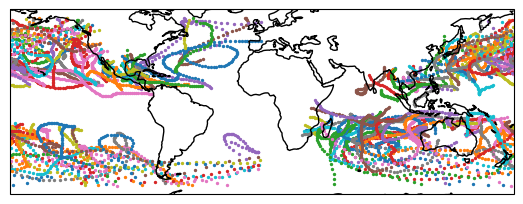

In [13]:
# Plot the last realization of syntheric TC tracks (one year):
import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature

MyFigsize,MyFontsize = (6.5,4),8
londis, latdis = 30, 15
lon1, lon2 = 10,350
lat1, lat2 = -60, 60
my_proj = ccrs.PlateCarree(central_longitude=180)
data_ccrs = ccrs.PlateCarree()

fig = plt.figure(figsize=MyFigsize)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(zorder=100)

for i, longen in enumerate(climInitLon):
    lat, lon = fst['lat'][:, i], fst['lon'][:, i]
    plt.scatter(lon, lat, s=2, transform=ccrs.PlateCarree())


## Step 3: Mean and Standard deviation of all the predictors
To calculate the mean and standard deviation of the predictors, we need to apply observed tracks over model fields for the period of 1980-2012 using getMeanStd.py. It is a single stand-alone script, so we are not running it here but providing you with the output: result_w.nc and results_l.nc.

## Step 4: Intensity

Using tracks and predictors calculated from Step 2, and predictors' mean and standard deviation from 'getMeanStd.py', we are now calculate storm intensity

In [14]:
class Processor():
    """Class container for processing stuff."""

    _counter = 0

    def addcounter(self):
        """Increment the counter."""
        # Some code here ...
        self._counter += 1

proc = Processor()

In [15]:
def get_E1(bt):
    """
    get errors and residual of errors from predictand bt
    return errors(E1), residual of errors(delta1), and ranges of v0 (cat1)
    """

    NS = np.argwhere((bt['StormYear'][:]>=1981)&(bt['StormYear'][:]<=2012))[:,0]
    #data = bt['errors'][:,NS,0]
    #data2 = bt.trueY[:,NS,0]
    data = bt['errors'][:,NS]
    data2 = bt['StormMwspd'][:,NS]

    for it in range(0,data.shape[1],1):
        data1 = data[:,it]
        data4 = data2[:,it]
        data4 = data4[data1==data1]
        data1 = data1[data1==data1]
        if 'E1' not in locals():
            E1 = data1[0:data1.shape[0]]
            E0 = data1[0:data1.shape[0]]
            v0E = data4[0:data4.shape[0]]
        else:
            E1 = np.hstack([E1,data1[0:data1.shape[0]]])
            E0 = np.hstack([E0,data1[0:data1.shape[0]]])
            v0E = np.hstack([v0E,data4[0:data4.shape[0]]])

    E2 = E0*E1*v0E
    E0 = E0[E2==E2]
    E1 = E1[E2==E2]
    v0E = v0E[E2==E2]
    c11,c0 = np.polyfit(E0,E1,1)

    c1 = v0E.min()
    c2 = v0E.max()
    for iC in np.arange(v0E.min(),v0E.max(),10):
        if v0E[v0E<iC].shape[0] > 50: c1 = iC; break
    for iC in np.arange(v0E.max(),v0E.min(),-10):
        if v0E[v0E>iC].shape[0] > 50: c2 = iC; break
    cat1 = np.arange(c1,c2+10,10) # range for Vinit

    return E0,v0E,cat1

def get_E1_delta1(bt):
    """
    get errors and residual of errors from predictand bt
    return errors(E1), residual of errors(delta1), and ranges of v0 (cat1)
    """

    iS1 = np.argwhere(bt['StormYear'][:]==1980)[0][0]
    iS2 = np.argwhere(bt['StormYear'][:]==1999)[-1][0]
    data = bt['errors'][:][:,iS1:iS2,1]
    data2 = bt['trueY'][:,:][:,iS1:iS2,0]

    for it in range(0,data.shape[1],1):
        data1 = data[:,it]
        data4 = data2[:,it]
        data4 = data4[data1==data1]
        data1 = data1[data1==data1]
        if 'E1' not in locals():
            E1 = data1[1:data1.shape[0]]
            E0 = data1[0:data1.shape[0]-1]
            v0E = data4[1:data4.shape[0]]
        else:
            E1 = np.hstack([E1,data1[1:data1.shape[0]]])
            E0 = np.hstack([E0,data1[0:data1.shape[0]-1]])
            v0E = np.hstack([v0E,data4[1:data4.shape[0]]])
    E2 = E0*E1*v0E
    E0 = E0[E2==E2]
    E1 = E1[E2==E2]
    v0E = v0E[E2==E2]
    c11,c0 = np.polyfit(E0,E1,1)

    for it in range(0,data.shape[1],1):
        data1 = data[:,it]
        data4 = data2[:,it]
        data4 = data4[data1==data1]
        data1 = data1[data1==data1]
        data3 =  data1[1:data1.shape[0]]-\
              (data1[0:data1.shape[0]-1]*c11)
        data4 = data4[1:]
        if 'delta1' not in locals():
            delta1 = data3[1:data3.shape[0]]
            delta0 = data3[0:data3.shape[0]-1]
            v0delta = data4[1:data4.shape[0]]
        else:
            delta1 = np.hstack([delta1,data3[1:data3.shape[0]]])
            delta0 = np.hstack([delta0,data3[0:data3.shape[0]-1]])
            v0delta = np.hstack([v0delta,data4[1:data4.shape[0]]])
    delta3 = delta1*delta0*v0delta
    delta1 = delta1[delta3==delta3]
    delta0 = delta0[delta3==delta3]
    v0delta = v0delta[delta3==delta3]

    c1 = v0delta.min()
    c2 = v0delta.max()
    for iC in np.arange(v0delta.min(),v0delta.max(),10):
        if v0delta[v0delta<iC].shape[0] > 50: c1 = iC; break
    for iC in np.arange(v0delta.max(),v0delta.min(),-10):
        if v0delta[v0delta>iC].shape[0] > 50: c2 = iC; break
    cat1 = np.arange(c1,c2+10,10) # range for Vinit

    return E0,v0E,delta1,cat1,v0delta,c11

def get_mean(meanFile,predictors):
    '''
    calculate mean in X and Y based on predictors
    '''
    hour = list(range(12,132,12))
    n2 = len(predictors)
    meanX = np.empty([len(hour),n2],dtype=float)+np.float64('nan')
    meanY = np.empty([len(hour)],dtype=float)+np.float64('nan')
    stdX  = np.empty([len(hour),n2],dtype=float)+np.float64('nan')
    stdY  = np.empty([len(hour)],dtype=float)+np.float64('nan')
    f = open(meanFile)
    b = f.readlines()
    f.close()
    count1 = 0
    for ih in hour:
        lm = b[ih/12].rstrip().rsplit()
        meanX[count1,:] = lm[3:3+n2]
        meanY[count1]  = lm[1]
        stdX[count1,:] = lm[3+n2::]
        stdY[count1]   = lm[2]
        count1 += 1
    return meanX,meanY,stdX,stdY

# Create a log of all random calls
random_call_log = []

#def findError(errort,v0E,v0,cat1):
def findError(errort, v0E, v0, cat1, storm_id, time_step, ensemble_member): 
    '''
    calculate error
    '''
    if (v0 == v0):
        if v0 <= cat1.min():
            j0 = 0
            error1 = errort[v0E<cat1[j0+1]]
        elif v0 >= cat1.max():
            j0 = len(cat1)-1
            error1 = errort[v0E>=cat1[j0]]
        else:
            [j0,j1] = find_range(cat1,v0)
            error1 = errort[((v0E>=cat1[j0]) & (v0E<cat1[j0+1]))]
        ## update to use set rng
        ##error = random.choice(error1)
        #error = rng.choice(error1)
        ## FREEZING RANDOM
        #error = error1[0]

        ## trying a local random
        local_seed = seed + ensemble_member * 1000000 + storm_id * 10000 + time_step * 10

        ## debugging
        random_call_log.append((ensemble_member, storm_id, time_step, local_seed))
        
        local_rng = np.random.default_rng(seed = local_seed)
        error = local_rng.choice(error1)

        proc.addcounter()


    else:
        error = 0
    return error

from bisect import bisect_left, bisect_right

def find_range(array, a):

    """
    Return two indices in which a is in between in an array
    array has to be a monotonic increase or decrease array
    """
    if (np.diff(array)<0).any():
        start = bisect_right(array[::-1],a)
        end = bisect_left(array[::-1],a)
        end = array.shape[0]-start
        start = end
    else:
        start = bisect_right(array,a)
        end = bisect_left(array,a)
    return (start-1, end)

In [16]:
def getPrediction_v0input_result(bt,meanX,meanY,stdX,stdY,it,index,fstperiod,result,predictors,TimeDepends,v0,dvdt):
        v1 = []
        h1 = []
        v1.append(v0)
        h1.append(bt.Time[it,index])
        for ih in fstperiod:
            h1.append(bt.Time[it,index]+timedelta(hours = ih))
            lT = int(ih/6)
            dy = result[0]#.params[0]
            count2 = 0
            for var in predictors:
                #print meanX.shape
                if var in 'SHRD':
                  rvar =nanmean(np.sqrt(bt.UShearMean[it:it+lT+1,index]**2+bt.VShearMean[it:it+lT+1,index]**2))
                elif var in 'dPIwspd':
                   rvar = nanmean(bt.PIwspdMean[it:it+lT+1,index])-v0
                elif var in TimeDepends:
                   rvar = nanmean(getattr(bt,var)[it:it+lT+1,index])
                elif var in 'StormMwspd':
                   rvar = v0
                elif var in 'dVdt':
                   rvar = dvdt
                elif var in 'landmaskMean':
                   rvar = getattr(bt,var)[it+lT+1,index]-getattr(bt,var)[it,index]
                elif var in 'StormMwspd2':
                   rvar = (getattr(bt,'StormMwspd')[it,index])**2
                elif var in 'StormMwspd3':
                   rvar = (getattr(bt,'StormMwspd')[it,index])**3
                elif var in 'MPI':
                   rvar = nanmean(bt.PIwspdMean[it:it+lT+1,index])
                elif var in 'MPI2':
                   rvar = nanmean(bt.PIwspdMean[it:it+lT+1,index])**2
                elif var in 'dPIwspd2':
                   rvar = (nanmean(bt.PIwspdMean[it:it+lT+1,index])-v0)**2
                elif var in 'dPIwspd3':
                   rvar = (nanmean(bt.PIwspdMean[it:it+lT+1,index])-v0)**3
                elif 'dVdt2' in var:
                   rvar = dvdt**2
                elif 'dVdt3' in var:
                   rvar = dvdt**3
                else:
                   rvar = getattr(bt,var)[it,index]
                #print var, rvar
                rvar = (rvar-meanX[count2+1])/stdX[count2+1]
                dy = dy + rvar*result[count2+1]
                count2 = count2 + 1
            dy = (dy*stdY)+meanY
            v1.append(v0+dy)
        return h1,v1



def get_determin(iiS,block_id=None):
    iS = np.int_(iiS.mean(keepdims=True))

    ## LOCAL RANDOM 
    ## using storm-based seed for initialization
    init_seed = seed + iS * 1000000 + 1  # +1 for init phase
    init_rng = np.random.default_rng(seed=init_seed)

    #iS  = iiS
    lT = 2
    dummy = bt.StormLon[:,iS][bt.StormLon[:,iS]==bt.StormLon[:,iS]]
    TimeDepends = ['dThetaEsMean','T200Mean','rhMean','rh500_300Mean','div200Mean']
    if ((dummy.any()) and (np.abs(bt.StormLat[0,iS])>=5.)):
        it1 = 0
        it2 = np.int_(np.min([np.argwhere(bt.StormLon[:,iS]==dummy[-1])[-1,0],bt.StormLon.shape[0]-5]))
        if ((bt.StormLat[0,iS] >=0) and (bt.StormLon[0,iS]>=120) and (bt.StormLon[0,iS]<=180)):
            ## update to use set rng
            ##bt.determin[0,iS] = np.max([20,random.choice(intV[intV==intV])]) # kts
            #bt.determin[0,iS] = np.max([20,rng.choice(intV[intV==intV])]) # kts

            ## FREEZING RANDOM
            #bt.determin[0, iS] = np.max([20, intV[intV==intV][0]])

            bt.determin[0,iS] = np.max([20,init_rng.choice(intV[intV==intV])]) # kts


        else:
            ##bt.determin[0,iS] = np.max([25,random.choice(intV[intV==intV])]) # kts
            #bt.determin[0,iS] = np.max([25,rng.choice(intV[intV==intV])]) # kts

            ## FREEZING RANDOM
            #bt.determin[0, iS] = np.max([25, intV[intV==intV][1]])

            bt.determin[0,iS] = np.max([25,init_rng.choice(intV[intV==intV])]) # kts


        #bt.determin[0,iS] = intV[iS] # kts
        dvdt = 0.0
        ih = 12
        lT = np.int_(ih/6) ### track model formate is every 12 hours
        v0 = bt.determin[0,iS]
        for it in range(it1,it2+2,2):
            if ((it+lT<bt.StormLon.shape[0]) and (bt.StormLon[it,iS]==bt.StormLon[it,iS])\
                    and (bt.landmaskMean[it,iS]==bt.landmaskMean[it,iS]) \
                    and (bt.landmaskMean[it+lT,iS]==bt.landmaskMean[it+lT,iS]) and not np.isnan(v0)):
                if(((bt.landmaskMean[it+lT,iS]<= -0.5)&(bt.landmaskMean[it,iS]<= -0.5))):
                    predictors=['StormMwspd','dVdt','trSpeed','dPIwspd','SHRD','rhMean','dPIwspd2','dPIwspd3','dVdt2']
                    result,meanX,meanY,stdX,stdY = copy.copy(result_w),copy.copy(meanX_w),\
                                                copy.copy(meanY_w),copy.copy(stdX_w),copy.copy(stdY_w)
                elif(((bt.landmaskMean[it+lT,iS]> -0.5)|(bt.landmaskMean[it,iS]> -0.5))):
                    predictors=['StormMwspd','dVdt','trSpeed','dPIwspd','SHRD','rhMean','dPIwspd2','dPIwspd3','dVdt2','landmaskMean']
                    result,meanX,meanY,stdX,stdY = copy.copy(result_l),copy.copy(meanX_l),\
                                                copy.copy(meanY_l),copy.copy(stdX_l),copy.copy(stdY_l)
                h1,v1 = getPrediction_v0input_result\
                         (bt,meanX,meanY,stdX,stdY,it,\
                         iS,[ih],result,predictors,\
                         TimeDepends,v0,dvdt)
                v1 = v1[1]
                if v1 < 10:
                    v1 = np.float64('Nan')
                    break;
                bt.determin[it+lT,iS] = v1
                if ((bt.determin[it1:it+lT:lT,iS].max()>35) and (bt.determin[it,iS]<=35) and (bt.determin[it-lT,iS]<=35)):
                    break;
                dvdt = v1-v0
                v0 = v1
        for iit in range(it1+1,np.min([it2+1,bt.StormLon.shape[0]-2]),2):
            a = bt.determin[iit-1,iS]*bt.determin[iit+1,iS]
            if a==a:
                bt.determin[iit,iS] = \
                0.5*(bt.determin[iit-1,iS]+bt.determin[iit+1,iS])
    return iS

def get_stochastic(iiS,block_id=None):
    TimeDepends = ['dThetaEsMean','T200Mean','rhMean','rh500_300Mean','div200Mean']
    iS = np.int_(iiS.mean(keepdims=True))
    dummy = bt.StormLon[:,iS][bt.StormLon[:,iS]==bt.StormLon[:,iS]]
    if ((dummy.any()) and (np.abs(bt.StormLat[0,iS])>=5.)):
        it1 = 0
        it2 = np.min([np.argwhere(bt.StormLon[:,iS]==dummy[-1])[-1,0],bt.StormLon.shape[0]-5])
        
        ## LOCAL RANDOM
        init_seed = seed + iNN * 1000000 + iS * 10000 + 1  # +1 for init phase
        init_rng = np.random.default_rng(seed=init_seed)

        if ((bt.StormLat[0,iS] >=0) and (bt.StormLon[0,iS]>=120) and (bt.StormLon[0,iS]<=180)):
            ## update to use set rng
            ##bt.stochastic[0,iS,iNN] = np.max([20,random.choice(intV[intV==intV])]) # kts
            #bt.stochastic[0, iS, iNN] = np.max([20, rng.choice(intV[intV==intV])]) #kts

            ## FREEZING RANDOM
            #bt.stochastic[0, iS, iNN] = np.max([20, intV[intV==intV][0]])

            bt.stochastic[0, iS, iNN] = np.max([20, init_rng.choice(intV[intV==intV])]) #kts


        else:
            ##bt.stochastic[0,iS,iNN] = np.max([25,random.choice(intV[intV==intV])]) # kts
            #bt.stochastic[0, iS, iNN] = np.max([25, rng.choice(intV[intV==intV])]) #kts

            ## FREEZING RANDOM
            #bt.stochastic[0, iS, iNN] = np.max([25, intV[intV==intV][1]])

            bt.stochastic[0, iS, iNN] = np.max([25, init_rng.choice(intV[intV==intV])])



        ih = 12
        lT = np.int_(ih/6)
        v0 = bt.stochastic[0,iS,iNN]
        dvdt = 0.
        for it in range(it1,it2+2,2):
            if ((it+lT<bt.StormLon.shape[0]) and (bt.StormLon[it,iS]==bt.StormLon[it,iS])\
                    and (bt.landmaskMean[it,iS]==bt.landmaskMean[it,iS]) \
                    and (bt.landmaskMean[it+lT,iS]==bt.landmaskMean[it+lT,iS]) and not np.isnan(v0)):
                if(((bt.landmaskMean[it+lT,iS]<= -0.5)&(bt.landmaskMean[it,iS]<= -0.5))):
                    predictors=['StormMwspd','dVdt','trSpeed','dPIwspd','SHRD','rhMean','dPIwspd2','dPIwspd3','dVdt2']
                    result,meanX,meanY,stdX,stdY = copy.copy(result_w),copy.copy(meanX_w),\
                                                copy.copy(meanY_w),copy.copy(stdX_w),copy.copy(stdY_w)
                elif(((bt.landmaskMean[it+lT,iS]> -0.5)|(bt.landmaskMean[it,iS]> -0.5))):
                    predictors=['StormMwspd','dVdt','trSpeed','dPIwspd','SHRD','rhMean','dPIwspd2','dPIwspd3','dVdt2','landmaskMean']
                    result,meanX,meanY,stdX,stdY = copy.copy(result_l),copy.copy(meanX_l),\
                                                copy.copy(meanY_l),copy.copy(stdX_l),copy.copy(stdY_l)
                h1,v1 = getPrediction_v0input_result\
                     (bt,meanX,meanY,stdX,stdY,it,\
                     iS,[ih],result,predictors,\
                     TimeDepends,v0,dvdt)
                ## LOCAL ERROR
                #error = findError(E0,v0E,v0,cat1)
                error = findError(E0, v0E, v0, cat1, iS, it, iNN)
                bt.error[it,iS,iNN] = error
                v1 = v1[1]
                v1 = v1-error
                if v1 < 10:
                    break;
                 #if ((it >= it1+4*lT) and (bt.stochastic[it,iS,iNN]<=35) and (bt.stochastic[it-lT,iS,iNN]<=35)):
                bt.stochastic[it+lT,iS,iNN] = v1
                if ((bt.stochastic[it1:it+lT:lT,iS,iNN].max()>35) and (bt.stochastic[it,iS,iNN]<=35) and (bt.stochastic[it-lT,iS,iNN]<=35)):
                    break;
                dvdt = v1-v0
                v0 = v1
        for iit in range(it1+1,np.min([it2+1,bt.StormLon.shape[0]-2]),2):
            a = bt.stochastic[iit-1,iS,iNN]*bt.stochastic[iit+1,iS,iNN]
            if a==a:
                bt.stochastic[iit,iS,iNN] = \
                    0.5*(bt.stochastic[iit-1,iS,iNN]+bt.stochastic[iit+1,iS,iNN])

    return iS


def calIntensity(iy,ichaz):
    ipath2 = './'
    global result_w, meanY_w, stdX_w, meanX_w, stdY_w
    global result_l, meanY_l, stdX_l, meanX_l, stdY_l

    opath = pooch.retrieve(url=f"{path_data}/{gv.obpath}",  known_hash=None)
    bt2 = nc.Dataset(opath,'r')
    fname = pooch.retrieve(url=f"{path_data}/result_w.nc",  known_hash=None)
    result_wi = nc.Dataset(fname, 'r') #gv.ipath +
    result_w = ma.getdata(result_wi['params'][:])
    fname = pooch.retrieve(url=f"{path_data}/result_l.nc",  known_hash=None)
    result_li = nc.Dataset(fname,'r') #gv.ipath +
    result_l = ma.getdata(result_li['params'][:])
    fname = pooch.retrieve(url=f"{path_data}/observed_data.nc",  known_hash=None)
    observed_data = nc.Dataset(fname, 'r') #gv.ipath +
    meanX_w_obs = ma.getdata(observed_data['meanX_w_obs'][:])
    stdX_w_obs = ma.getdata(observed_data['stdX_w_obs'][:])
    meanY_w_obs = ma.getdata(observed_data['meanY_w_obs'][:])
    stdY_w_obs = ma.getdata(observed_data['stdY_w_obs'][:])
    meanX_l_obs = ma.getdata(observed_data['meanX_l_obs'][:])
    stdX_l_obs = ma.getdata(observed_data['stdX_l_obs'][:])
    meanY_l_obs = ma.getdata(observed_data['meanY_l_obs'][:])
    stdY_l_obs = ma.getdata(observed_data['stdY_l_obs'][:])

    NS = np.argwhere((bt2['StormYear'][:]>=1981)&(bt2['StormYear'][:]<=2012))[:,0]
    global E0, v0E, cat1, intV
    intV = bt2['StormMwspd'][:][0,NS]
    E0, v0E,cat1, = get_E1(bt2)
    del bt2

    #read the synthetic tracks
    global bt
    with open(f'trackPredictorsbt{iy:04d}_ens{ichaz:03d}.pik','rb')as f:
        bt = pickle.load(f)
        f.close()
    ### read mean and std from the HIST data
    fopen = pooch.retrieve(url=f"{path_data}/coefficient_meanstd.nc",  known_hash=None)
    coeff_meanstd = nc.Dataset(fopen,'r')
    meanX_w = ma.getdata(coeff_meanstd['meanX_w'][:])
    stdX_w = ma.getdata(coeff_meanstd['stdX_w'][:])
    meanY_w = ma.getdata(coeff_meanstd['meanY_w'][:])
    stdY_w = ma.getdata(coeff_meanstd['stdY_w'][:])
    meanX_l = ma.getdata(coeff_meanstd['meanX_l'][:])
    stdX_l = ma.getdata(coeff_meanstd['stdX_l'][:])
    meanY_l = ma.getdata(coeff_meanstd['meanY_l'][:])
    stdY_l = ma.getdata(coeff_meanstd['stdY_l'][:])

    nsto = gv.CHAZ_Int_ENS
    bt.__dict__['determin'] = np.zeros(bt.StormLon.shape)*np.float64('nan')
    bt.__dict__['stochastic'] = np.zeros([bt.StormLon.shape[0],bt.StormLon.shape[1],nsto])*np.float64('nan')
    bt.__dict__['error'] = np.zeros([bt.StormLon.shape[0],bt.StormLon.shape[1],nsto])*np.float64('nan')

    NS = np.arange(0,bt.StormYear.shape[0],1)
    #NNS1,NNS2 = np.meshgrid(NS,np.arange(0,nsto,1))
    #nnS1 = da.from_array(NNS1.ravel().astype(dtype=np.int32),chunks=(1,))
    #nnS2 = da.from_array(NNS2.ravel().astype(dtype=np.int32),chunks=(1,))
    nS = da.from_array(NS.astype(dtype=np.int32),chunks=(1,))

    new = da.map_blocks(get_determin,nS,chunks=(1,), dtype=nS.dtype)
    with ProgressBar():
        n = new.compute(scheduler='synchronous',num_workers=5)
    del new
    gc.collect()
    #for iS in NS:
    #    print iS
    #    b = get_determin(np.array([iS, iS]))
    #print 'down calculate deterministic'

    new =da.map_blocks(get_stochastic,nS,chunks=(1,), dtype=nS.dtype)
    global iNN
    for iNN in range(nsto):
        time1 = time.time()
        with ProgressBar():
            n = new.compute(scheduler='synchronous',num_workers=5)
        gc.collect()
        #print iNN,time.time()-time1
    del new

    #with open (f'output/bt_stochastic_det{iy:04d}_ens{ichaz:03d}.pik','wb') as f:
        #pickle.dump(bt,f)
    #f.close()

    ## save the log 
    #np.save('random_calls_original.npy', np.array(random_call_log))
    with open('random_calls_original.pkl', 'wb') as f:
        pickle.dump(random_call_log, f)

    return bt

In [17]:
%%time
tc_downscaled = calIntensity(yearTC, gv.CHAZ_ENS)

[########################################] | 100% Completed | 418.96 ms
[########################################] | 100% Completed | 729.58 ms
[########################################] | 100% Completed | 833.68 ms
[########################################] | 100% Completed | 842.44 ms
[#########################               ] | 63% Completed | 522.18 ms

/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_14851/1300374970.py:34: RuntimeWarning: overflow encountered in square
  rvar = (nanmean(bt.PIwspdMean[it:it+lT+1,index])-v0)**2
/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_14851/1300374970.py:36: RuntimeWarning: overflow encountered in power
  rvar = (nanmean(bt.PIwspdMean[it:it+lT+1,index])-v0)**3
/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_14851/1300374970.py:38: RuntimeWarning: overflow encountered in square
  rvar = dvdt**2
/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_14851/1300374970.py:45: RuntimeWarning: invalid value encountered in add
  dy = dy + rvar*result[count2+1]


[########################################] | 100% Completed | 834.94 ms
[########################################] | 100% Completed | 842.77 ms
[########################################] | 100% Completed | 837.60 ms
[########################################] | 100% Completed | 730.36 ms
[########################################] | 100% Completed | 724.49 ms
[########################################] | 100% Completed | 841.38 ms
[########################################] | 100% Completed | 833.78 ms
[########################################] | 100% Completed | 835.04 ms
[########################################] | 100% Completed | 837.10 ms
[########################################] | 100% Completed | 826.93 ms
[########################################] | 100% Completed | 840.83 ms
[########################################] | 100% Completed | 849.07 ms
[########################################] | 100% Completed | 834.84 ms
[########################################] | 100% Completed | 84

/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_14851/1300374970.py:195: RuntimeWarning: overflow encountered in multiply
  a = bt.stochastic[iit-1,iS,iNN]*bt.stochastic[iit+1,iS,iNN]


[########################################] | 100% Completed | 943.30 ms
[########################################] | 100% Completed | 834.33 ms
[########################################] | 100% Completed | 934.97 ms
[########################################] | 100% Completed | 829.46 ms
[########################################] | 100% Completed | 841.47 ms
[########################################] | 100% Completed | 828.41 ms
[########################################] | 100% Completed | 830.84 ms
[########################################] | 100% Completed | 824.73 ms
CPU times: user 32.5 s, sys: 3.47 s, total: 36 s
Wall time: 38.3 s


In [18]:
print("Deterministic shape:", bt.determin.shape)
print("Stochastic shape:", bt.stochastic.shape)
print("Error shape:", bt.error.shape)

Deterministic shape: (125, 124)
Stochastic shape: (125, 124, 40)
Error shape: (125, 124, 40)


## Step 5: Clean up and save to NetCDF format



In [19]:

def getbasinMap(ifplot=False):
        xbin, ybin = np.arange(0,365,5),np.arange(-90,95,5)
        xcenter = 0.5*(xbin[0:-1]+xbin[1:])
        ycenter = 0.5*(ybin[0:-1]+ybin[1:])
        basinMap = np.zeros([xcenter.shape[0],ycenter.shape[0]])
        lonc,latc = np.meshgrid(xcenter,ycenter)
        n_sin = np.argwhere((lonc<90) & (latc<0)&(latc>=-45))
        n_aus = np.argwhere((lonc>=90)&(lonc<160)&(latc<0)&(latc>=-45))
        n_spc = np.argwhere((lonc>=160)&(lonc<240)&(latc<0)&(latc>=-45))
        n_ni = np.argwhere((lonc<100) & (latc>=0)&(latc<=45))
        n_wnp = np.argwhere((lonc>=100)&(lonc<180)&(latc>=0)&(latc<=45))
        n_enp = np.argwhere(((lonc>=180)&(lonc<235)&(latc>=0)&(latc<=45)))
        n_atl = np.argwhere((lonc>=235)&(latc>=0)&(latc<=45))

        basinMap[n_atl[:,1],n_atl[:,0]]=1
        basinMap[n_enp[:,1],n_enp[:,0]]=2
        basinMap[n_wnp[:,1],n_wnp[:,0]]=3
        basinMap[n_ni[:,1],n_ni[:,0]]=4
        basinMap[n_sin[:,1],n_sin[:,0]]=5
        basinMap[n_aus[:,1],n_aus[:,0]]=6
        basinMap[n_spc[:,1],n_spc[:,0]]=7
        a= np.arange(xcenter.shape[0]*ycenter.shape[0]).reshape(xcenter.shape[0],ycenter.shape[0])

        basinMap[a==1716] = 2
        basinMap[a==1715] = 2
        basinMap[a==1714] = 2
        basinMap[a==1713] = 2
        basinMap[a==1712] = 2
        basinMap[a==1711] = 2
        basinMap[a==1710] = 2
        basinMap[a==1751] = 2
        basinMap[a==1750] = 2
        basinMap[a==1749] = 2
        basinMap[a==1748] = 2
        basinMap[a==1747] = 2
        basinMap[a==1746] = 2
        basinMap[a==1787] = 2
        basinMap[a==1786] = 2
        basinMap[a==1785] = 2
        basinMap[a==1784] = 2
        basinMap[a==1783] = 2
        basinMap[a==1782] = 2
        basinMap[a==1822] = 2
        basinMap[a==1821] = 2
        basinMap[a==1820] = 2
        basinMap[a==1819] = 2
        basinMap[a==1818] = 2
        basinMap[a==1854] = 2
        basinMap[a==1855] = 2
        basinMap[a==1856] = 2
        basinMap[a==1857] = 2
        basinMap[a==1890] = 2
        basinMap[a==1891] = 2
        basinMap[a==1892] = 2
        basinMap[a==1893] = 2
        basinMap[a==1926] = 2
        basinMap[a==1927] = 2
        basinMap[a==1928] = 2
        basinMap[a==1962] = 2
        basinMap[a==1963] = 2
        basinMap[a==1964] = 2
        #basinMap[a==1680] = 7
        #basinMap[a==1681] = 7
        #basinMap[a==1683] = 7
        basinMap[a==1714] = 2
        basinMap[a==1718] = 2
        basinMap[a==1719] = 2
        basinMap[a==1716] = 2
        basinMap[a==1717] = 2
        basinMap[a==1753] = 2
        basinMap[a==1752] = 2
        basinMap[a==1754] = 2
        basinMap[a==1755] = 2
        basinMap[a==1785] = 2
        basinMap[a==1786] = 2
        basinMap[a==1787] = 2
        basinMap[a==1821] = 2
        basinMap[a==1822] = 2
        basinMap[a==1823] = 2
        basinMap[a==1752] = 2
        basinMap[a==1753] = 2
        basinMap[a==1754] = 2
        basinMap[a==1755] = 2
        basinMap[a==1785] = 2
        basinMap[a==1786] = 2
        basinMap[a==1787] = 2
        basinMap[a==1821] = 2
        basinMap[a==1822] = 2
        basinMap[a==1823] = 2
        basinMap[a==1752] = 2
        basinMap[a==1753] = 2
        basinMap[a==1998] = 2
        basinMap[a==1999] = 2

        return xbin,ybin,basinMap

def defineBasin(lon0_obs,lat0_obs,basinlon,basinlat,basinMap):

        ### avoid NaN
        basin = np.zeros(lon0_obs.shape)
        ###
        lat0_obs[lat0_obs>=90] = 89.9
        lat0_obs[lat0_obs<=-90] = -89.9
        notNaN_arg = np.where(~np.isnan(lon0_obs*lat0_obs))
        x = np.floor(lon0_obs[notNaN_arg]/np.diff(basinlon)[0])
        y = np.floor((lat0_obs[notNaN_arg]-basinlat[0])/np.diff(basinlat)[0])
        x[x==basinMap.shape[0]] = basinMap.shape[0]-1
        y[y==basinMap.shape[1]] = basinMap.shape[1]-1
        basin[notNaN_arg] = basinMap[np.int_(x),np.int_(y)]
        return(basin)


In [20]:

xbin,ybin,basinMap = getbasinMap()

bt1 = copy.copy(tc_downscaled)
lon0,lat0 = bt1.StormLon[0,:],bt1.StormLat[0,:]
basin = defineBasin(lon0,lat0,xbin,ybin,basinMap)

#### get rid of storms  that has never developed
bt1.stochastic[bt1.stochastic==0] = np.float64('nan')
max5 = np.nanmax(bt1.stochastic[0:21,:,:],axis=0)
iS1 = np.argwhere(max5<35)[:,0]
iN1 = np.argwhere(max5<35)[:,1]
bt1.stochastic[:,iS1,iN1] = np.float64('nan')
maxall = np.nanmax(bt1.stochastic,axis=0)
v0 = bt1.stochastic[0,:,:]
#### get rid of storms that becoming unstable
iS1 = np.argwhere(maxall>300)[:,0]
iN1 = np.argwhere(maxall>300)[:,1]
bt1.stochastic[:,iS1,iN1] = np.float64('nan')
#### get rid of storms that initially formed with 2 degree lon,lat
iS1 = np.argwhere(np.abs(bt1.StormLat[0,:])<2)[:,0]
bt1.stochastic[:,iS1,:] = np.float64('nan')
bt1.StormLon[0,iS1] = np.float64('nan')
iS1 = np.argwhere(basin==0)
bt1.StormLon[0,iS1] = np.float64('nan')

#### get rid of storms that have no intensity record
maxall = np.nanmax(bt1.stochastic,axis=0)
#changed
iS1 = np.argwhere(maxall<=0)[:,0]
iN1 = np.argwhere(maxall<=0)[:,1]
bt1.stochastic[:,iS1,iN1] = np.float64('nan')
#bt1.stochastic[:,basin!=1,:] = np.float('nan')
arg = np.argwhere(bt1.StormLon[0,:] == bt1.StormLon[0,:])[:][:,0]

newlon = bt1.StormLon[:,arg]
newlat = bt1.StormLat[:,arg]
newwspd = bt1.stochastic[:,arg]
newdatenum = bt1.Time[:,arg]
newYear = bt1.StormYear[arg]
newMonth = bt1.StormInitMonth[arg]

#dummy dataframe
ensembleNum = np.arange(newwspd.shape[2])
stormID = np.arange(arg.shape[0])
lifelength = np.arange(newdatenum.shape[0])

ds = xr.Dataset({
  'longitude': xr.DataArray(
  data = newlon,
  dims = ['lifelength','stormID'],
  coords = {'lifelength':lifelength, 'stormID':stormID},
  attrs = {
    '_FillValue': np.float64('nan'),
    'units': 'degrees east'}
  ),
  'latitude': xr.DataArray(
  data = newlat,
  dims = ['lifelength','stormID'],
  coords = {'lifelength':lifelength, 'stormID':stormID},
  attrs = {
      '_FillValue': np.float64('nan'),
      'units'     : 'degrees north'
      }
  ),
  'Mwspd': xr.DataArray(
  data =np.rollaxis(newwspd,2,0),
  dims = ['ensembleNum','lifelength','stormID'],
  coords = {'ensembleNum':ensembleNum,'lifelength':lifelength, 'stormID':stormID},
  attrs = {
      '_FillValue': np.float64('nan'),
      'units'     : 'kt'
      }
  ),
  'year': xr.DataArray(
  data = newYear,
  dims = ['stormID'],
  coords = {'stormID':stormID},
  attrs = {
      'units'     : 'year'
      }
  ),
  'time': xr.DataArray(
  data = date2num(newdatenum, units='days since 1950-01-01 00:00', calendar='standard'),
  dims = ['lifelength','stormID'],
  coords = {'lifelength':lifelength, 'stormID':stormID},
  attrs = {
      'units'     : 'days since 1950-01-01 00:00'
      }
  )
})

file_name = f'{yearTC:04d}_001.nc'
print(file_name)
ds.to_netcdf(file_name)


2017_001.nc


/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_14851/709267180.py:9: RuntimeWarning: All-NaN slice encountered
  max5 = np.nanmax(bt1.stochastic[0:21,:,:],axis=0)
/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_14851/709267180.py:13: RuntimeWarning: All-NaN slice encountered
  maxall = np.nanmax(bt1.stochastic,axis=0)
/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_14851/709267180.py:27: RuntimeWarning: All-NaN slice encountered
  maxall = np.nanmax(bt1.stochastic,axis=0)


In [21]:
print(proc._counter)

60291


In [22]:
print("Deterministic shape:", bt.determin.shape)
print("Stochastic shape:", bt.stochastic.shape)
print("Error shape:", bt.error.shape)

Deterministic shape: (125, 124)
Stochastic shape: (125, 124, 40)
Error shape: (125, 124, 40)


# Step 6: Basic Checking

*   Track color-coded with intensity, we use intensity ensemble #0




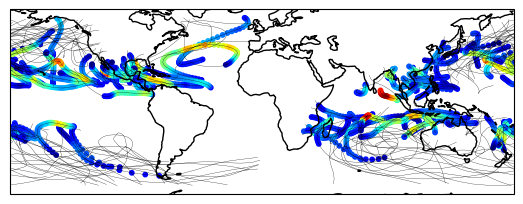

In [23]:
import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature

MyFigsize,MyFontsize = (6.5,4),8
londis, latdis = 30, 15
lon1, lon2 = 10,350
lat1, lat2 = -60, 60
my_proj = ccrs.PlateCarree(central_longitude=180)
data_ccrs = ccrs.PlateCarree()

fig = plt.figure(figsize=MyFigsize)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(zorder=100)
lon = ds['longitude'].values
lat = ds['latitude'].values
mwspd = ds['Mwspd'].values
plt.plot(lon,lat,'k-',transform=ccrs.PlateCarree(),linewidth=0.2)
plt.scatter(lon.ravel(),lat.ravel(),s=10,c=mwspd[1,:,:].ravel(),transform=ccrs.PlateCarree(), cmap='jet')
#plt.colorbar()

*   Intensity evoluation of a track #9



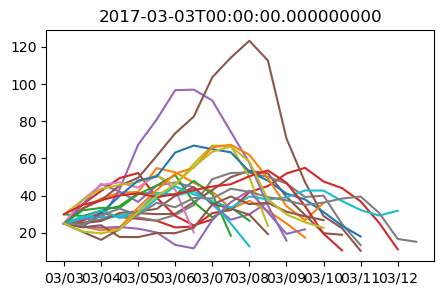

In [24]:
import matplotlib.dates as mdates

fig,ax = plt.subplots(figsize=(5,3))
time_1d = ds.time.values.reshape(-1)
df_chaz_t = pd.to_datetime(time_1d,unit='D',origin=pd.Timestamp('1950-01-01'))
origional_shape = ds.time.values.shape
df_chaz_t = df_chaz_t.to_numpy().reshape(origional_shape)
plt.plot(df_chaz_t[:,22],mwspd[:,:,22].T)
plt.title(df_chaz_t[0,22])
myFmt = mdates.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(myFmt)



*   Lifetime Maximum Intensity distribution

/var/folders/72/gq_qh34d21xgnsw2_5sf25rh0000gn/T/ipykernel_14851/2662542693.py:1: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(ds['Mwspd'].values,axis=1)


Text(0.5, 1.0, 'LMI')

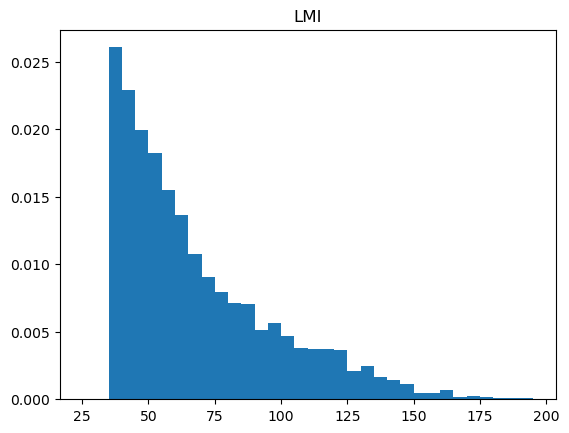

In [25]:
vmax = np.nanmax(ds['Mwspd'].values,axis=1)
plt.hist(vmax.flatten(), bins=np.arange(25,200,5), density=True, )
plt.title('LMI')